### Import Library

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

### panggil dataset

In [2]:
sdir=r'dataset'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                       filepaths         labels
0    dataset\Sawi Ada Hama\1.png  Sawi Ada Hama
1   dataset\Sawi Ada Hama\10.png  Sawi Ada Hama
2  dataset\Sawi Ada Hama\100.png  Sawi Ada Hama
3  dataset\Sawi Ada Hama\101.png  Sawi Ada Hama
4  dataset\Sawi Ada Hama\102.png  Sawi Ada Hama
Sawi Ada Hama      500
Sawi Tanpa Hama    500
Name: labels, dtype: int64


### proses k-hold atau split dataset
- data training 80%
- data testing 10 %
- data validation 10 %

In [3]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  800   test_df length:  100   valid_df length:  100


### membuat data testing, training dan validation menggunakan ImageDataGenerator

In [4]:
height = 128
width = 128
channels = 3
batch_size = 64

# Definisi dimensi gambar
img_shape = (height, width, channels)
img_size = (height, width)

length = len(test_df)

# Menghitung ukuran batch optimal untuk data pengujian
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)

print('test batch size:', test_batch_size, '  test steps:', test_steps)

# Membuat objek ImageDataGenerator untuk data pelatihan
gen = ImageDataGenerator(rescale=1./255)
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Membuat objek ImageDataGenerator untuk data validasi
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', shuffle=True, batch_size=batch_size)

# Membuat objek ImageDataGenerator untuk data pengujian
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=test_batch_size)

# Mendapatkan daftar kelas dari generator data pelatihan
classes = list(train_gen.class_indices.keys())
print(classes)

# Menghitung jumlah kelas
class_count = len(classes)


test batch size: 50   test steps: 2
Found 799 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
['Sawi Ada Hama', 'Sawi Tanpa Hama']


d:\INSTALASI\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


### menampilkan beberapa gambar dari generator

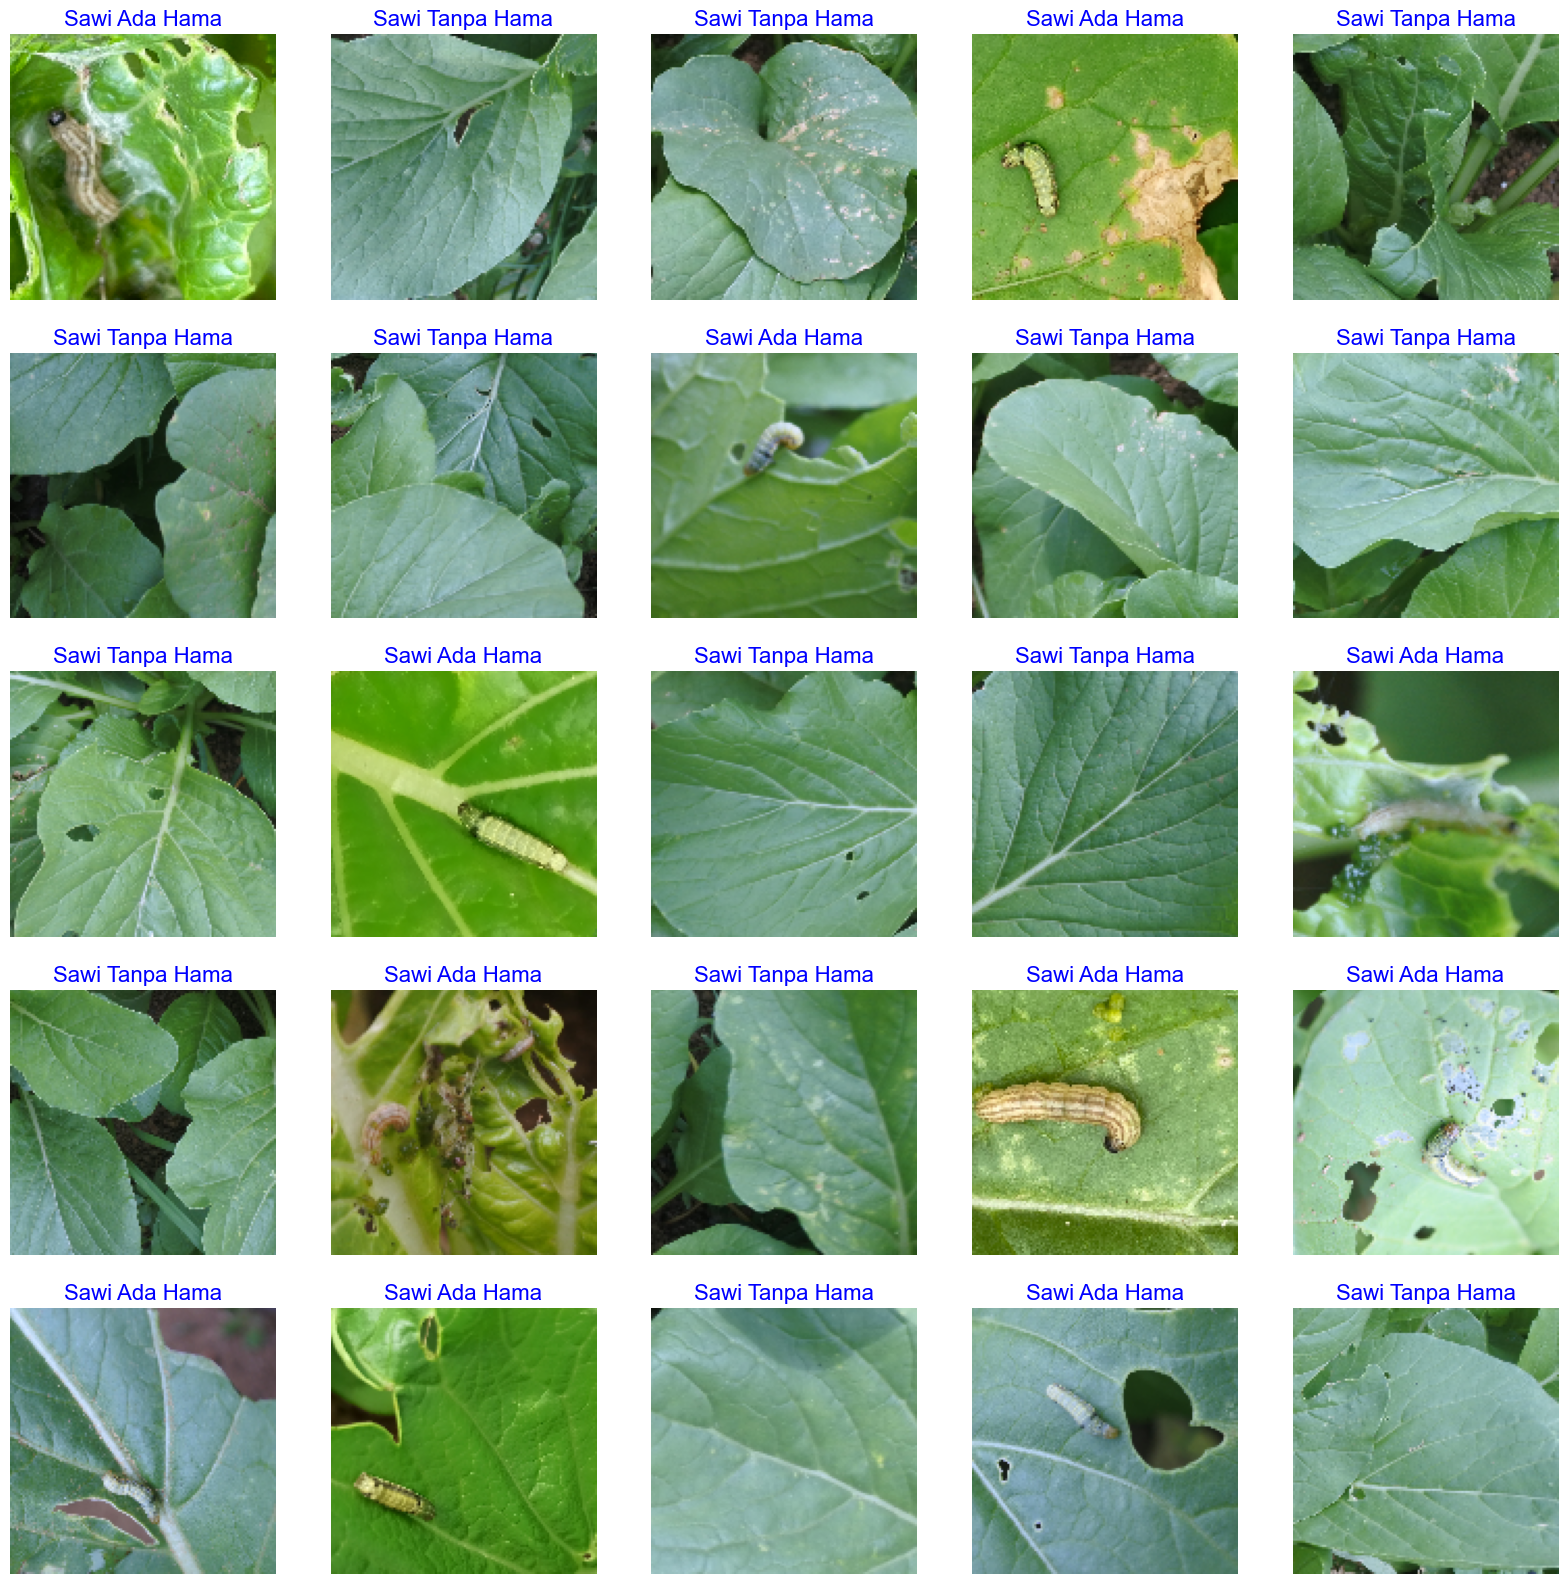

In [6]:
def show_image_samples(gen):
    test_dict = test_gen.class_indices
    classes = list(test_dict.keys())
    images, labels = next(gen)  # Mengambil satu batch contoh dari generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:   # Menampilkan maksimal 25 gambar
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()
show_image_samples(train_gen)


### membuat model menggunakan arsitektur Xception
- include_top=False digunakan untuk menghilangkan layer fully connected (top layer) pada model, sehingga hanya mempertahankan bagian konvolusi dari Xception.
- weights="imagenet" menentukan bahwa kita ingin menggunakan bobot yang telah dilatih pada dataset ImageNet untuk model Xception
- `base_model.summary()` mencetak ringkasan (summary) dari base_model, yaitu model dasar yang telah diinisialisasi dengan arsitektur Xception.
- Ringkasan ini akan menampilkan informasi tentang lapisan-lapisan (layers) dalam model, jumlah parameter yang dapat diatur, dan jumlah parameter yang tidak dapat diatur 
- `base_model.trainable = False` digunakan untuk mengatur parameter-parameter (weights) dalam base_model menjadi tidak dapat diubah (non-trainable). Dengan mengatur trainable menjadi False, kita mematikan kemampuan model untuk melakukan pembelajaran berbasis gradient (gradient-based learning), sehingga bobot-bobot yang ada dalam model tidak akan diperbarui selama proses pelatihan.

In [7]:
base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_tensor=Input(shape=(128, 128, 3)))
base_model.summary()
base_model.trainable = False

83683744/83683744 [==============================] - 150s 2us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                        

### cetak model
-  nama model  `sawi`
- `mode.compile` untuk optimasi model dengan optimizer `Adam`


In [11]:
model_name = 'sawi'
print("Building model with", base_model)

model = tf.keras.Sequential([
    # bentuk input adalah ukuran gambar yang diinginkan 128x128 dengan 3 byte warna
    base_model,
    tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')


Building model with <keras.engine.functional.Functional object at 0x00000233C17CBD00>


### melatih model menggunakan data train selama 10 epoch

In [12]:
epochs = 10

history = model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)


Epoch 1/10
13/13 [==============================] - 102s 8s/step - loss: 0.5510 - accuracy: 0.8135 - val_loss: 0.1802 - val_accuracy: 0.9400
Epoch 2/10
13/13 [==============================] - 96s 7s/step - loss: 0.1634 - accuracy: 0.9312 - val_loss: 0.1358 - val_accuracy: 0.9500
Epoch 3/10
13/13 [==============================] - 83s 6s/step - loss: 0.1220 - accuracy: 0.9612 - val_loss: 0.1137 - val_accuracy: 0.9500
Epoch 4/10
13/13 [==============================] - 80s 6s/step - loss: 0.1001 - accuracy: 0.9662 - val_loss: 0.1244 - val_accuracy: 0.9500
Epoch 5/10
13/13 [==============================] - 82s 6s/step - loss: 0.0845 - accuracy: 0.9662 - val_loss: 0.1764 - val_accuracy: 0.9400
Epoch 6/10
13/13 [==============================] - 65s 5s/step - loss: 0.0980 - accuracy: 0.9625 - val_loss: 0.1242 - val_accuracy: 0.9500
Epoch 7/10
13/13 [==============================] - 77s 6s/step - loss: 0.0575 - accuracy: 0.9837 - val_loss: 0.1686 - val_accuracy: 0.9400
Epoch 8/10
 9/13 [=

### cetak teks dengan background RGB

In [ ]:
def print_in_color(txt_msg, fore_tupple, back_tupple):
    # Mencetak pesan teks (txt_msg) dengan warna latar depan (fore_tupple) dan latar belakang (back_tupple) yang ditentukan.
    # txt_msg adalah teks yang akan dicetak, fore_tupple adalah tupel warna latar depan (r, g, b), back_tupple adalah tupel warna latar belakang (r, g, b)
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'
    print(msg.format(mat), flush=True)
    print('\33[0m', flush=True)  # Mengembalikan warna cetakan default menjadi hitam
    return
